In [154]:
# Installations
#conda install -c conda-forge librosa
#conda install -c conda-forge ffmpeg
#You may need to restart the kernel (or close the jupyter notebook and restart) after installations

In [144]:
# imports

#General
import numpy as np
import pandas as pd
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image


# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Configurations
path='./data/'

## Get filenames

In [134]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 36 audio files in ./data/


## Labeling the data

In [135]:
# Get Labels
labels =[]
classes=['ney','piano','santour', 'setar','tar','violin']
color_dict={'ney':'blue', 'piano':'red', 'santour':'green', 'setar':'black', 'tar':'magenta', 'violin':'yellow'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, './data/'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

## Encode Labels

In [136]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: ney, piano, santour, setar, tar, violin


## Parameters for MFCC

In [137]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

## Function to Calculate Audio Features: MFCC

In [138]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    #select just mfcc
    #feature_vector = np.mean(mfcc,1)
    
    #select mfcc and delta and delta2 as features
    delta_mfccs = librosa.feature.delta(mfcc)
    delta2_mfccs = librosa.feature.delta(mfcc, order=2)
    feature_vector = np.concatenate((mfcc, delta_mfccs, delta2_mfccs))
    feature_vector = np.mean(feature_vector,1)
    
    return feature_vector

## Load audio files, calculate features and create feature vectors

In [139]:
# Load audio files, calculate features and create feature vectors
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 36 = ./data/ney\1.mp3


C:\Users\hamed\anaconda3\envs\for_sql\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


get 2 of 36 = ./data/ney\ني - حجاز  (آلبوم شوق) - زمان خيري.mp3


KeyboardInterrupt: 

## Save feature vectors and labels

In [118]:
data=pd.DataFrame(feature_vectors)
data.index.name='Sample'
data['label']=pd.DataFrame(classes_num)
data.to_csv('data.csv')

## Load feature vectors and labels

In [140]:
data=pd.read_csv('data.csv', index_col='Sample')
#feature_vectors=data.iloc[:,0:n_mfcc]
feature_vectors=data.iloc[:,0:n_mfcc*3]
classes_num=data['label']

## Standardization: Zero-Mean and Unit-Variance

In [141]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (36, 39)


## Train and Test Sets

In [142]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=42)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [143]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (27, 39)
test_set shape: (9, 39)
train_classes shape: (27,)
test_classes shape: (9,)


## Logistic Regression Classification

In [145]:
# logistic Regression Classifier
model_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [146]:
# kNN
model_lg.fit(train_set, train_classes);

In [147]:
# Predict using the Test Set
predicted_labels = model_lg.predict(test_set)

## Evaluation

In [148]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [1.  1.  1.  0.5 0.5 1. ]
Precision:  [1.  1.  1.  0.5 0.5 1. ]
F1-Score:  [1.  1.  1.  0.5 0.5 1. ]
Accuracy: 0.78  , 7
Number of samples: 9


In [149]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [150]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

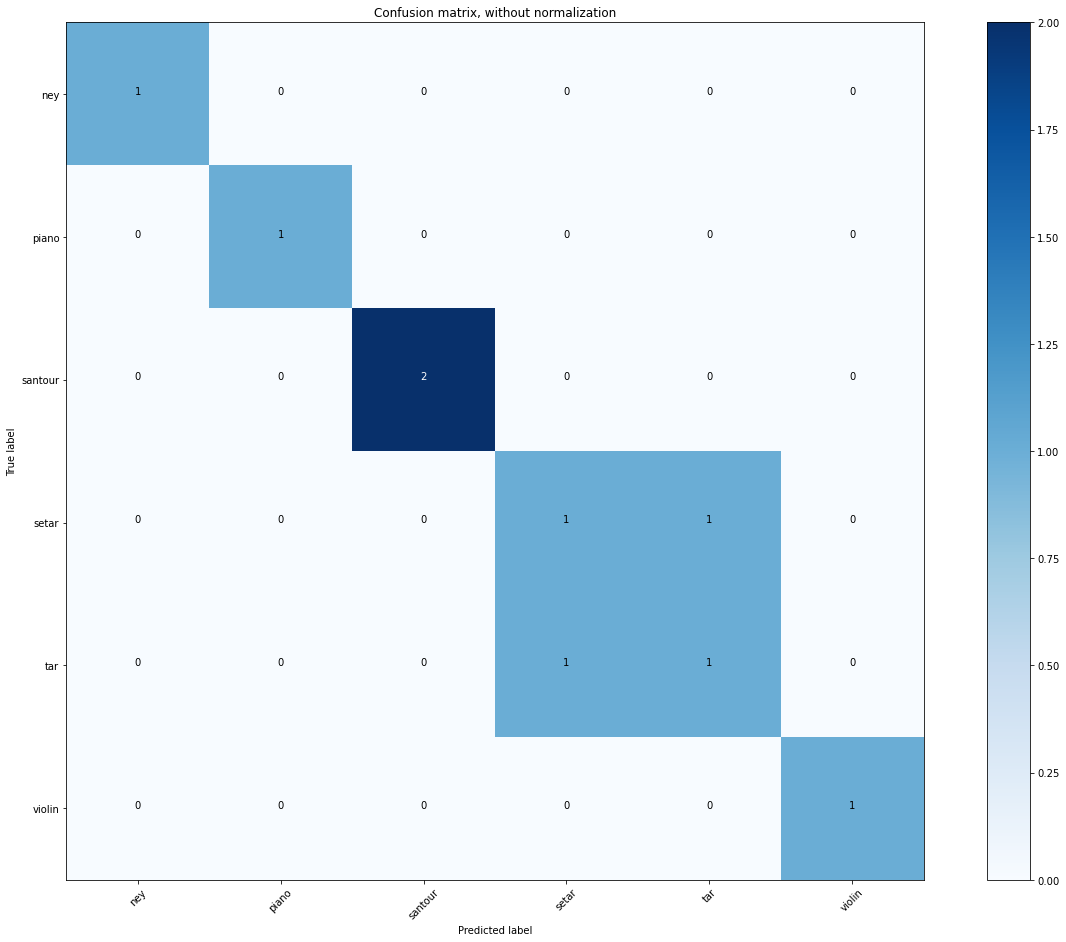

In [151]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [152]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [153]:
 #Find wrong predicted audio files
print('True labels are:')    
print(np.array(labels)[test_index[wrong_predictions]])
#print(predicted_labels[wrong_predictions].T)
print('Predicted labels are:')  
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
print('Wrong files are:')
for i, index in enumerate(wrong_predictions):
    print('File #%d:' %i,np.array(files)[test_index[index]])

True labels are:
['setar' 'tar']
Predicted labels are:
['tar' 'setar']
Wrong files are:
File #0: ./data/setar\سه تار - دستگاه راست پنج گانه - احمد عبادي.mp3
File #1: ./data/tar\تار - وارياسيون بر روي تصنيف عاشق - ميثم ملكي.mp3
